In [1]:
import os
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import mapping, box
from rasterio.mask import mask
from IPython.display import display
import matplotlib.pyplot as plt

In [8]:
raster_files = [
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202301_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202302_bil.bil",
    "/Users/Rk/Downloads/School/GROWER/SpringTask2/PRISM_tmean_stable_4kmM3_2023_all_bil/PRISM_tmean_stable_4kmM3_202312_bil.bil",
]

shapefile_path = "/Users/Rk/Downloads/School/GROWER/SpringTask2/nhgis0002_shape/nhgis0002_shapefile_tl2023_us_zcta_2023/US_zcta_2023.shp"

zip_field = "ZCTA5CE20"

zip_intervals = [(30000, 31999), (39800, 39999)]

scale_factor = 1.0


In [9]:
def zip_in_intervals(zip_val, intervals):
    try:
        z = int(zip_val)
        for (low, high) in intervals:
            if low <= z <= high:
                return True
        return False
    except (ValueError, TypeError):
        return False

In [10]:
zip_gdf = gpd.read_file(shapefile_path)
display(zip_gdf.head())

# Filter the GeoDataFrame based on the provided zip_intervals.
filtered_gdf = zip_gdf[zip_gdf[zip_field].apply(lambda z: zip_in_intervals(z, zip_intervals))].copy()
print(f"Number of ZIP-code polygons after filtering: {len(filtered_gdf)}")
display(filtered_gdf.head())

,GISJOIN,ZCTA5CE20,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,ORIG_FID,geometry
0,G00601,00601,00601,860Z200US00601,B5,G6350,S,166848592.0,798613.0,+18.1805555,-066.7499615,82697.360499,1.676472e+08,8825,"POLYGON ((3174440.254 -1631886.38, 3174447.084..."
1,G00602,00602,00602,860Z200US00602,B5,G6350,S,78546711.0,4428428.0,+18.3619450,-067.1755974,50765.076072,7.876919e+07,8892,"POLYGON ((3118392.408 -1625931.35, 3118394.308..."
2,G00603,00603,00603,860Z200US00603,B5,G6350,S,88980555.0,6253316.0,+18.4573986,-067.1248670,55417.260840,8.914236e+07,8802,"POLYGON ((3117543.256 -1612404.317, 3117547.37..."
3,G00606,00606,00606,860Z200US00606,B5,G6350,S,114825641.0,12228.0,+18.1583269,-066.9329285,78796.420501,1.148379e+08,8815,"POLYGON ((3154840.517 -1638879.219, 3154862.89..."
4,G00610,00610,00610,860Z200US00610,B5,G6350,S,96150194.0,4289688.0,+18.2953043,-067.1251799,68201.943372,9.677966e+07,8826,"POLYGON ((3129371.721 -1631728.349, 3130354.02..."


Number of ZIP-code polygons after filtering: 751


,GISJOIN,ZCTA5CE20,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,ORIG_FID,geometry
9755,G30002,30002,30002,860Z200US30002,B5,G6350,S,4396684.0,35621.0,+33.7733346,-084.2616669,15215.757214,4.432313e+06,8988,"POLYGON ((1077914.053 -348863.734, 1077946.386..."
9756,G30004,30004,30004,860Z200US30004,B5,G6350,S,150061243.0,1833185.0,+34.1456348,-084.2918814,111252.827546,1.518944e+08,10167,"POLYGON ((1076462.385 -310484.892, 1076425.655..."
9757,G30005,30005,30005,860Z200US30005,B5,G6350,S,40898014.0,897460.0,+34.0890498,-084.2170187,44413.582070,4.179547e+07,10173,"POLYGON ((1080231.492 -315323.551, 1080270.3 -..."
9758,G30008,30008,30008,860Z200US30008,B5,G6350,S,24713437.0,27393.0,+33.9005668,-084.5909235,40124.671955,2.474083e+07,7121,"MULTIPOLYGON (((1041671.072 -344769.488, 10416..."
9759,G30009,30009,30009,860Z200US30009,B5,G6350,S,23587579.0,200005.0,+34.0781363,-084.3034243,43656.113886,2.378760e+07,10176,"MULTIPOLYGON (((1066024.52 -315541.079, 106601..."


In [11]:
with rasterio.open(raster_files[0]) as src_ref:
    raster_crs = src_ref.crs

# Reproject the filtered GeoDataFrame if necessary.
if filtered_gdf.crs != raster_crs:
    filtered_gdf = filtered_gdf.to_crs(raster_crs)

seasonal_mean_temps = []  # This will store the seasonal mean temperature for each polygon.

# Loop over each polygon in the filtered GeoDataFrame.
for idx, row in filtered_gdf.iterrows():
    geom = row['geometry']
    monthly_means = []  # List to hold the mean for each raster (month) for this polygon.

    # Process each raster file.
    for raster_path in raster_files:
        with rasterio.open(raster_path) as src:
            try:
                # Clip the raster to the current polygon geometry.
                out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                # Reshape the output so that each band is a 1D array.
                data = out_image.reshape(out_image.shape[0], -1)

                # Replace nodata values with NaN.
                if src.nodata is not None:
                    data = np.where(data == src.nodata, np.nan, data)

                # Count valid (non-NaN) pixels.
                valid_pixels = np.count_nonzero(~np.isnan(data))
                if valid_pixels > 0:
                    # Compute the mean for this raster (month) and apply the scale factor if needed.
                    month_mean = np.nanmean(data) * scale_factor
                    monthly_means.append(month_mean)
                else:
                    monthly_means.append(np.nan)
            except Exception as e:
                print(f"Error processing polygon index {idx} in file {raster_path}: {e}")
                monthly_means.append(np.nan)

    # Compute the seasonal mean by averaging the monthly means (ignoring NaN values).
    if monthly_means and np.count_nonzero(~np.isnan(monthly_means)) > 0:
        seasonal_mean = np.nanmean(monthly_means)
    else:
        seasonal_mean = np.nan
    seasonal_mean_temps.append(seasonal_mean)
filtered_gdf['seasonal_mean_temp'] = seasonal_mean_temps

display(filtered_gdf.head())

,GISJOIN,ZCTA5CE20,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,ORIG_FID,geometry,seasonal_mean_temp
9755,G30002,30002,30002,860Z200US30002,B5,G6350,S,4396684.0,35621.0,+33.7733346,-084.2616669,15215.757214,4.432313e+06,8988,"POLYGON ((-84.2465 33.78705, -84.24628 33.7861...",NaN
9756,G30004,30004,30004,860Z200US30004,B5,G6350,S,150061243.0,1833185.0,+34.1456348,-084.2918814,111252.827546,1.518944e+08,10167,"POLYGON ((-84.21052 34.12945, -84.21102 34.128...",8.958090
9757,G30005,30005,30005,860Z200US30005,B5,G6350,S,40898014.0,897460.0,+34.0890498,-084.2170187,44413.582070,4.179547e+07,10173,"POLYGON ((-84.17622 34.08231, -84.17579 34.082...",9.017966
9758,G30008,30008,30008,860Z200US30008,B5,G6350,S,24713437.0,27393.0,+33.9005668,-084.5909235,40124.671955,2.474083e+07,7121,"MULTIPOLYGON (((-84.63255 33.86278, -84.63254 ...",9.829101
9759,G30009,30009,30009,860Z200US30009,B5,G6350,S,23587579.0,200005.0,+34.0781363,-084.3034243,43656.113886,2.378760e+07,10176,"MULTIPOLYGON (((-84.33045 34.09605, -84.33056 ...",8.983466


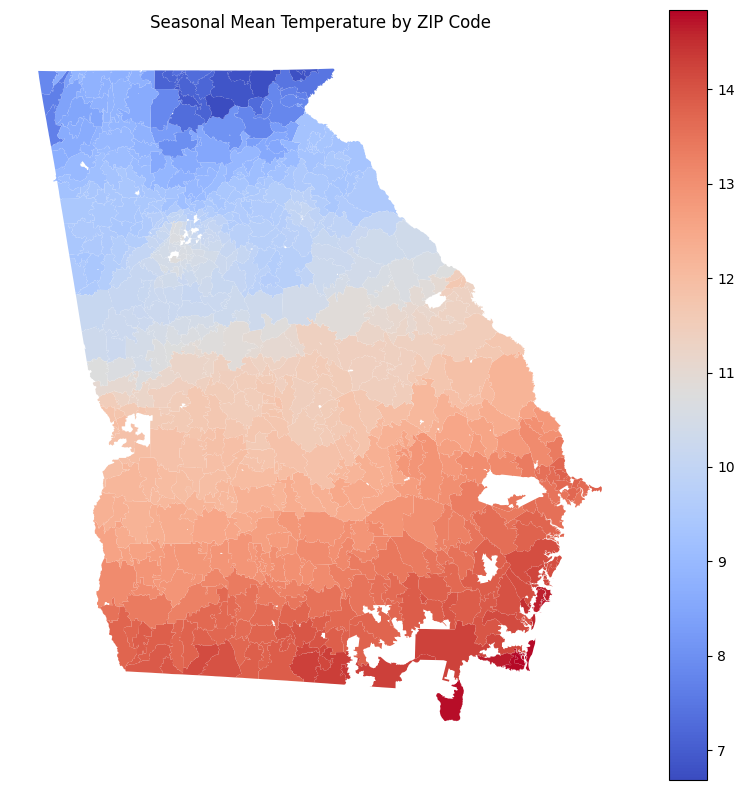

In [12]:
ax = filtered_gdf.plot(column='seasonal_mean_temp', cmap='coolwarm', legend=True, figsize=(10, 10))
ax.set_title('DJF  Mean Temperature by ZIP Code')
ax.set_axis_off()
plt.show()